In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from ripser import Rips
import persim
from keras.models import load_model

In [2]:
tickers_df = pd.read_csv("../feature_extraction/valid_tickers.csv")
tickers = tickers_df["ticker"].tolist()

In [3]:
end_date = datetime(2025, 1, 1).date()  # datetime.now().date()
start_date = end_date - timedelta(days=90) 
# (30 days for prediction, 1 day for first day na log return, 30 days for window + 1 day for first day of window) / (5/7 trading days)

tickers_df = pd.read_csv("../feature_extraction/valid_tickers.csv")
tickers = tickers_df["ticker"].tolist()

sp500_data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker")

/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/3347293885.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker")
[*********************100%***********************]  474 of 474 completed


In [4]:
print(len(sp500_data))

62


In [5]:
df_finance = sp500_data.copy()
df_finance.columns = [f"{col[0]}_{col[1]}" for col in df_finance.columns]

df_finance = df_finance.reset_index()
df_finance = df_finance.set_index('Date')

In [6]:
window_rsi = 14
window_vol = 21

def compute_rsi(series, window):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain, index=series.index).rolling(window=window).mean()
    roll_down = pd.Series(loss, index=series.index).rolling(window=window).mean()
    
    RS = np.where(roll_down == 0, np.inf, roll_up / roll_down)
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

for ticker in tickers:
    close_col = f"{ticker}_Close"
    volume_col = f"{ticker}_Volume"

    if close_col not in df_finance.columns or volume_col not in df_finance.columns:
        continue

    df_finance[f"{ticker}_RSI_14"] = compute_rsi(df_finance[close_col], window=window_rsi)
    
    log_return = np.log(1 + df_finance[close_col].pct_change())
    df_finance[f"{ticker}_Log_Return"] = log_return
    df_finance[f"{ticker}_Volatility_21"] = log_return.rolling(window=window_vol).std()
    
    df_finance[f"{ticker}_Volume_Z"] = (df_finance[volume_col] - df_finance[volume_col].rolling(window_vol).mean()) / df_finance[volume_col].rolling(window_vol).std()
# Drop first row due to NaN values
df_finance = df_finance.iloc[1:]

/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/2417404046.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_finance[f"{ticker}_RSI_14"] = compute_rsi(df_finance[close_col], window=window_rsi)
/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/2417404046.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_finance[f"{ticker}_Log_Return"] = log_return
/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/2417404046.py:27: PerformanceWarning: DataFrame is highly fragmented.  This 

In [7]:
window_wasserstein = 30
eps = 0.5  
maxdim = 2 
rips = Rips(maxdim=maxdim, verbose=False)

def betti_numbers_at_scale(diagrams, eps):
    bettis = []
    for dgm in diagrams:
        alive = np.sum((dgm[:, 0] <= eps) & (dgm[:, 1] > eps))
        bettis.append(int(alive))
    return bettis

first_ticker = list(tickers)[0]

log_returns = np.array([df_finance[f"{ticker}_Log_Return"].dropna() for ticker in tickers])

persistences = []
betti_list = []
wasserstein_list = []

for start in range(0, len(log_returns.T) - window_wasserstein + 1):
    window_data = log_returns[start:start + window_wasserstein].T
    diagrams = rips.fit_transform(window_data)
    persistences.append(diagrams)

    bettis = betti_numbers_at_scale(diagrams, eps=eps)
    while len(bettis) < 3:
        bettis.append(0)
    betti_list.append(bettis)

for i in range(1, len(persistences)):
    dgm_prev = persistences[i - 1][1]
    dgm_curr = persistences[i][1]
    W = persim.wasserstein(dgm_prev, dgm_curr)
    wasserstein_list.append(W)

betti_df = pd.DataFrame(
    betti_list,
    columns=["Betti0", "Betti1", "Betti2"],
    index=df_finance.index[window_wasserstein - 1:]
)
wasserstein_df = pd.DataFrame(
    {"Wasserstein": wasserstein_list},
    index=df_finance.index[window_wasserstein:]
)

df_finance["Wasserstein"] = wasserstein_df.reindex(df_finance.index)["Wasserstein"]

for col in ["Betti0", "Betti1", "Betti2"]:
    df_finance[col] = betti_df.reindex(df_finance.index)[col]

df_finance = df_finance[sorted(df_finance.columns)]
df_finance = df_finance.iloc[window_wasserstein:]

/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/1210345410.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_finance["Wasserstein"] = wasserstein_df.reindex(df_finance.index)["Wasserstein"]
/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/1210345410.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_finance[col] = betti_df.reindex(df_finance.index)[col]
/var/folders/c5/nwrhnbhs5ks1ssf190f4b49r0000gn/T/ipykernel_71704/1210345410.py:50: PerformanceWarning: DataFrame is highly fragmented.

In [8]:
df_finance = df_finance[sorted(df_finance.columns)]

In [9]:
df_finance.columns = pd.MultiIndex.from_tuples(
    [(col.split("_")[0], "_".join(col.split("_")[1:])) for col in df_finance.columns]
)

train_features = ['Close', 'High', 'Low', 'Open', 'RSI_14', 'Volatility_21', 'Volume', 'Volume_Z', 'Sentiment']

In [10]:
sp500 = pd.read_csv("../sp500.csv")
symbol_to_security = sp500.set_index("Symbol")["Security"].to_dict()

In [11]:
df_articles = pd.DataFrame().reindex(df_finance.index)

In [12]:
"""
from gdeltdoc import GdeltDoc, Filters
from gdeltdoc.errors import RateLimitError
from urllib.parse import quote
from datetime import date

gdd = GdeltDoc()
articles = None;

import time

for ticker in tickers:
    if ticker in df_articles.columns:
        print(f"Skipping {ticker}, already in df_articles")
        continue

    keyword = symbol_to_security[ticker]
    print(keyword)
    if len(ticker) <= 3:
        keyword += " News"
    filters = Filters(
        keyword=quote(keyword), 
        start_date=str(start_date), 
        end_date=str(end_date),
        num_records = 1,
    )
    print(str(start_date), str(end_date))

    while True:
        try:
            articles = gdd.article_search(filters)
            print(articles)
            print(keyword, "done")
            break
        except RateLimitError as e:
            print(f"Rate limit hit for {ticker}, waiting 5s before retrying...")
            time.sleep(5)
        except Exception as e:
            print(f"Error for {ticker}: {e}")
            articles = pd.DataFrame()
            break

    if not articles.empty:
        articles = articles[["title", "seendate"]]
        dates = pd.to_datetime(articles["seendate"].str[:8], format="%Y%m%d")
        articles.drop(columns=["seendate"], inplace=True)
        articles.set_index(dates, inplace=True)
        articles.rename(columns={"title": ticker}, inplace=True)
        articles.index.name = "Date"

        articles = articles[~articles.index.duplicated(keep='first')]
        valid_dates = articles.index.intersection(df_articles.index)
        df_articles.loc[valid_dates, ticker] = articles.loc[valid_dates, ticker]
    else:
        df_articles[ticker] = np.nan
"""

'\nfrom gdeltdoc import GdeltDoc, Filters\nfrom gdeltdoc.errors import RateLimitError\nfrom urllib.parse import quote\nfrom datetime import date\n\ngdd = GdeltDoc()\narticles = None;\n\nimport time\n\nfor ticker in tickers:\n    if ticker in df_articles.columns:\n        print(f"Skipping {ticker}, already in df_articles")\n        continue\n\n    keyword = symbol_to_security[ticker]\n    print(keyword)\n    if len(ticker) <= 3:\n        keyword += " News"\n    filters = Filters(\n        keyword=quote(keyword), \n        start_date=str(start_date), \n        end_date=str(end_date),\n        num_records = 1,\n    )\n    print(str(start_date), str(end_date))\n\n    while True:\n        try:\n            articles = gdd.article_search(filters)\n            print(articles)\n            print(keyword, "done")\n            break\n        except RateLimitError as e:\n            print(f"Rate limit hit for {ticker}, waiting 5s before retrying...")\n            time.sleep(5)\n        except Exce

In [13]:
import requests
import feedparser
import time

import warnings
warnings.filterwarnings('ignore')

count = 0

for ticker in tickers:
    if ticker in df_articles.columns:
        print(f"Skipping {ticker}, already in df_articles")
        continue

    keyword = symbol_to_security[ticker]
    print(keyword)
    if len(ticker) <= 3:
        keyword += " stock"

    # Build the Google News RSS query
    query = f'{keyword} after:{start_date} before:{end_date}'
    feed_url = f'https://news.google.com/rss/search?q={query}'

    try:
        response = requests.get(feed_url, headers={'User-Agent': 'Mozilla/5.0'})
        feed = feedparser.parse(response.text)
        
        titles = []
        dates = []

        for entry in feed.entries:
            if 'title' in entry and 'published' in entry:
                titles.append(entry['title'])
                try:
                    article_date = pd.to_datetime(entry['published'], errors='coerce').normalize()
                except Exception:
                    continue
                dates.append(article_date)
        
        if titles and dates:
            articles_df = pd.DataFrame({
                'title': titles,
                'date': dates
            })

            articles_df.set_index('date', inplace=True)
            articles_df.rename(columns={'title': ticker}, inplace=True)
            articles_df.index.name = 'Date'

            # Remove duplicates and align with df_articles
            articles_df = articles_df[~articles_df.index.duplicated(keep='first')]
            valid_dates = articles_df.index.intersection(df_articles.index)

            if len(valid_dates) > 0:
                df_articles.loc[valid_dates, ticker] = articles_df.loc[valid_dates, ticker]
            else:
                df_articles[ticker] = np.nan

            print(f"{keyword} done - found {len(titles)} articles")
        else:
            df_articles[ticker] = np.nan
            print(f"{keyword} done - no valid articles or no results")

    except Exception as e:
        print(f"Error for {ticker}: {e}")
        df_articles[ticker] = np.nan
        
    count += 1
    print(count)

Synopsys
Synopsys done - found 72 articles
1
CDW Corporation
CDW Corporation stock done - found 7 articles
2
Skyworks Solutions
Skyworks Solutions done - found 10 articles
3
Labcorp
Labcorp stock done - found 15 articles
4
LKQ Corporation
LKQ Corporation stock done - found 9 articles
5
Visa Inc.
Visa Inc. stock done - found 45 articles
6
Fortive
Fortive stock done - found 5 articles
7
Meta Platforms
Meta Platforms done - found 100 articles
8
Incyte
Incyte done - found 36 articles
9
FedEx
FedEx stock done - found 76 articles
10
Estée Lauder Companies (The)
Estée Lauder Companies (The) stock done - found 48 articles
11
AbbVie
AbbVie done - found 100 articles
12
Alliant Energy
Alliant Energy stock done - found 12 articles
13
Chubb Limited
Chubb Limited stock done - found 39 articles
14
IBM
IBM stock done - found 88 articles
15
PayPal
PayPal done - found 100 articles
16
Newmont
Newmont stock done - found 51 articles
17
Edwards Lifesciences
Edwards Lifesciences stock done - found 30 article

In [14]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

def print_nlp(text):
  if text is None or pd.isna(text):
    return "Neutral"
  res = nlp(text)
  return res

Device set to use mps:0


In [15]:
import torch
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import gc

# Set device to 'mps' for Apple Silicon (M1/M2/M3 chips), fallback to 'cpu' if unavailable
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch_dtype = torch.float32  # MPS only supports float32/float16
    print("Using device: Apple Silicon (mps)")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

model_name = "ProsusAI/finbert"  # adjust if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to correct device
bert_model = bert_model.to(device)

# Huggingface pipeline handles device=-1 as "CPU"/MPS; only CUDA allows GPU index and large batches
# With MPS only a single batch at a time is generally supported well. We'll set batch_size=8 (tune as needed)
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=bert_model,
    tokenizer=tokenizer,
    device=-1,                # device=-1 for CPU and MPS with PyTorch >1.13
    batch_size=8,             # Keep batch small for compatibility
    return_all_scores=True
)

def batch_process_texts(texts, batch_size=8):
    """Batch process texts; works for M1/M2 Mac (MPS) or CPU"""
    results = []

    valid_texts = [str(text) if text and str(text).strip() else "" for text in texts]

    for i in tqdm(range(0, len(valid_texts), batch_size), desc="Processing batches"):
        batch = valid_texts[i:i+batch_size]

        # Process batch
        batch_results = sentiment_pipeline(batch)

        batch_labels = []
        for result in batch_results:
            if isinstance(result, list) and len(result) > 0:
                # Get the label with highest score
                best_result = max(result, key=lambda x: x['score'])
                batch_labels.append(best_result['label'])
            else:
                batch_labels.append("NEUTRAL")  # fallback

        results.extend(batch_labels)

        # Clear cache periodically (MPS no empty_cache, just collect)
        if i % (batch_size * 10) == 0:
            gc.collect()

    return results

# Flatten dataframe to array
text_array = df_articles.values.flatten()
print(f"Processing {len(text_array)} texts...")

results = batch_process_texts(text_array, batch_size=8)

# Reshape to dataframe as before
finbert_sentiment_df = pd.DataFrame(
    np.array(results).reshape(df_articles.shape),
    index=df_articles.index,
    columns=df_articles.columns
)

gc.collect()  # extra cleanup

finbert_sentiment_df

Using device: Apple Silicon (mps)


Device set to use mps:0


Processing 14694 texts...


Processing batches: 100%|██████████| 1837/1837 [01:20<00:00, 22.75it/s]


,SNPS,CDW,SWKS,LH,LKQ,V,FTV,META,INCY,FDX,...,MCHP,EQIX,RMD,DD,BA,CLX,ALL,AMCR,BK,BBY
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-15,neutral,neutral,neutral,neutral,neutral,negative,neutral,neutral,neutral,neutral,...,neutral,neutral,neutral,neutral,neutral,neutral,positive,neutral,neutral,neutral
2024-11-18,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,negative,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2024-11-19,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,negative,neutral,...,neutral,neutral,neutral,neutral,negative,positive,neutral,neutral,neutral,neutral
2024-11-20,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2024-11-21,neutral,neutral,neutral,neutral,neutral,neutral,neutral,positive,neutral,neutral,...,neutral,positive,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2024-11-22,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,...,neutral,negative,neutral,neutral,positive,neutral,neutral,neutral,neutral,neutral
2024-11-25,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,positive,neutral,...,neutral,negative,positive,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2024-11-26,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,...,neutral,negative,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2024-11-27,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,positive,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral


In [16]:
#finbert_sentiment_num_df = pd.read_csv("finbert_sentiment_df.csv")

finbert_sentiment_num_df = finbert_sentiment_df.replace(
    {"neutral": 0, "positive": 1, "negative": -1}
)
finbert_sentiment_num_df.index = pd.to_datetime(finbert_sentiment_num_df.index)

for ticker in tickers:
  df_finance[(ticker, "Sentiment")] = finbert_sentiment_num_df[ticker]

In [17]:
import joblib

scaler = joblib.load("scaler.pkl")

window_prediction = 30

X_all = []
ticker_names = []

# Process each ticker separately for window extraction,
# using the same scaler that was fitted during training
for ticker in tickers:
    try:
        df_ticker_finance = df_finance[ticker]
        df_predict = df_ticker_finance[train_features].copy()
        df_predict = df_predict.merge(df_finance["Wasserstein"].loc[df_predict.index], left_index=True, right_index=True)
        df_predict[train_features] = scaler.transform(df_predict[train_features])
    except Exception as e:
        print(f"Error {ticker}: {e}")
        continue

    # Use all 30 days, if available
    if len(df_predict) >= window_prediction:
        X_window = df_predict[train_features].iloc[-window_prediction:].values
        X_all.append(X_window)
        ticker_names.append(ticker)
    else:
        print(f"Not enough data for ticker {ticker} (has {len(df_predict)} rows) to form the required window.")

X_all = np.array(X_all)
print(f"Prepared data for {len(ticker_names)} tickers")
print(f"Input shape: {X_all.shape}")

Prepared data for 474 tickers
Input shape: (474, 30, 9)


In [ ]:
model = load_model("lstm.keras", compile=False)
predictions = model.predict(X_all)

results_df = pd.DataFrame({
    'Ticker': ticker_names,
    'Prediction': predictions.flatten()
})

print("AAPL", results_df[results_df["Ticker"] == "AAPL"])

print("Predictions:")
print(results_df.head(10))

print(f"\nPrediction Statistics:")
print(f"Mean prediction: {predictions.mean():.4f}")
print(f"Std prediction: {predictions.std():.4f}")
print(f"Min prediction: {predictions.min():.4f}")
print(f"Max prediction: {predictions.max():.4f}")

print(f"\nTop 10 Most Bullish Predictions:")
top_bullish = results_df.nlargest(10, 'Prediction')
print(top_bullish)

print(f"\nTop 10 Most Bearish Predictions:")
top_bearish = results_df.nsmallest(10, 'Prediction')
print(top_bearish)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
AAPL     Ticker  Prediction
422   AAPL    0.000435
Predictions:
  Ticker  Prediction
0   SNPS    0.000435
1    CDW    0.000435
2   SWKS    0.000435
3     LH    0.000435
4    LKQ    0.000435
5      V    0.000435
6    FTV    0.000435
7   META    0.000435
8   INCY    0.000435
9    FDX    0.000435

Prediction Statistics:
Mean prediction: 0.0004
Std prediction: 0.0015
Min prediction: -0.0295
Max prediction: 0.0107

Top 10 Most Bullish Predictions:
    Ticker  Prediction
310   SMCI    0.010711
373     MU    0.004126
175     LW    0.003084
47    AXON    0.002661
454    CRM    0.000635
0     SNPS    0.000435
1      CDW    0.000435
2     SWKS    0.000435
3       LH    0.000435
4      LKQ    0.000435

Top 10 Most Bearish Predictions:
   Ticker  Prediction
93   ENPH   -0.029459
0    SNPS    0.000435
1     CDW    0.000435
2    SWKS    0.000435
3      LH    0.000435
4     LKQ    0.000435
5       V    0.000435
6     FTV    0.000435
7    META    0.000435
8    I

<Axes: xlabel='Ticker'>

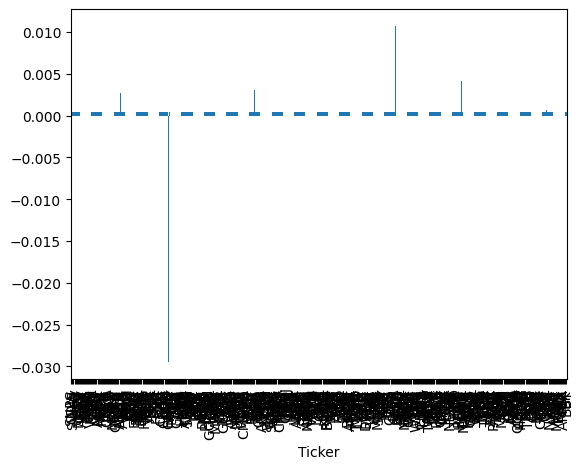

In [27]:
results_df.plot(kind='bar', x='Ticker', y='Prediction', legend=False)